# Diplomatura en Ciencia de Datos UTN FRC
## Modulo 3
### Trabajo práctico 

#### Alumno: Pavelek Israel

Los objetivos principales del proyecto son dos:

* Identificar la base de clientes con mayor potencial para la venta de producto/s
* Implementar algoritmos de clustering para segmentar la base de clientes

## Carga del Data Set

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display_html
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster import hierarchy
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN


pd.set_option('display.float_format', lambda x: '%.3f' % x)

df = pd.read_csv("Mall_Customers.csv") 
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


# Análisis exploratorio de datos

In [2]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000,200.000,200.000,200.000
mean,100.500,38.850,60.560,50.200
std,57.879,13.969,26.265,25.824
min,1.000,18.000,15.000,1.000
25%,50.750,28.750,41.500,34.750
50%,100.500,36.000,61.500,50.000
75%,150.250,49.000,78.000,73.000
max,200.000,70.000,137.000,99.000


In [3]:
df.isna().value_counts()

CustomerID  Gender  Age    Annual Income (k$)  Spending Score (1-100)
False       False   False  False               False                     200
dtype: int64

In [4]:
df.nunique()

CustomerID                200
Gender                      2
Age                        51
Annual Income (k$)         64
Spending Score (1-100)     84
dtype: int64

<AxesSubplot:ylabel='None'>

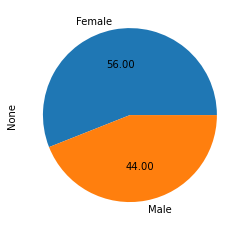

In [5]:
df.groupby('Gender').size().plot(kind='pie', autopct='%.2f')

<AxesSubplot:xlabel='Spending Score (1-100)', ylabel='Count'>

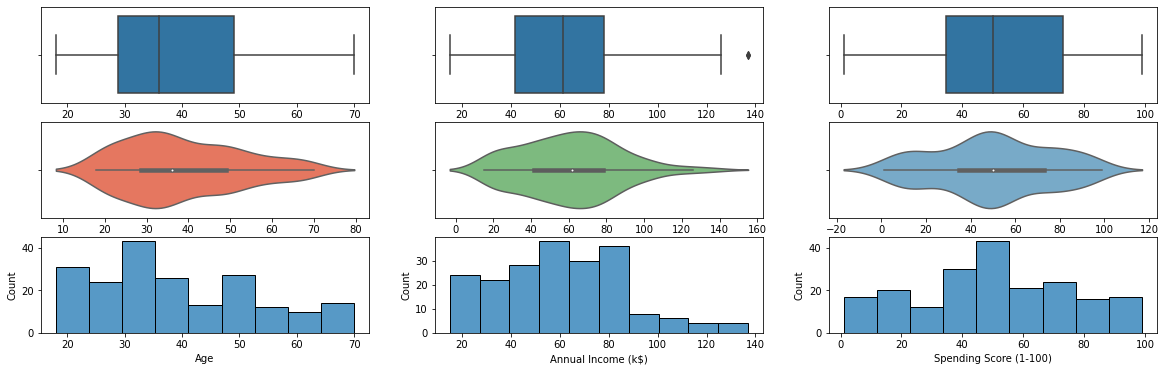

In [6]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20,6))

sns.boxplot(x=df['Age'], ax=axes[0][0])
sns.boxplot(x=df['Annual Income (k$)'], ax=axes[0][1])
sns.boxplot(x=df['Spending Score (1-100)'], ax=axes[0][2])

sns.violinplot(x=df['Age'], ax=axes[1][0], palette="Reds")
sns.violinplot(x=df['Annual Income (k$)'], ax=axes[1][1], palette="Greens")
sns.violinplot(x=df['Spending Score (1-100)'], ax=axes[1][2], palette="Blues")

sns.histplot(data=df, x=df['Age'],  ax=axes[2][0])
sns.histplot(data=df, x=df['Annual Income (k$)'],ax=axes[2][1])
sns.histplot(data=df, x=df['Spending Score (1-100)'],  ax=axes[2][2])

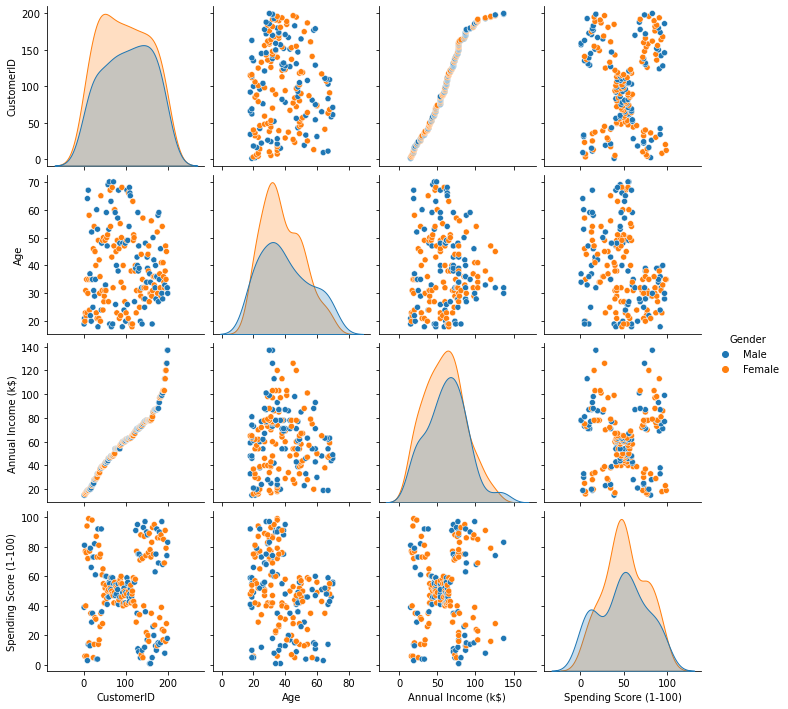

In [7]:
sns.pairplot(data=df, hue="Gender")

Como lineamiento general para la segmentación:

* No se utilizará el género y la edad para evitar introducir sesgos,
* No se utilizará el id de cliente ya que es un identificador único y no aporta valor a la segmentación de cliente.
* Lo anterior reduce el espacio de variables para la segmentación a: ingresos anuales y score de gastos

In [8]:
df_original = df.copy()


In [9]:
gender_mapper = {'Female': 0, 'Male': 1}
df['Gender'] = df['Gender'].map(gender_mapper)

Text(0.5, 1.0, 'Análisis de correlación')

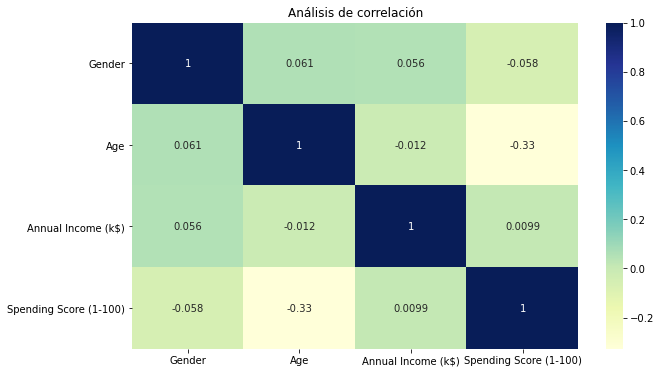

In [10]:
plt.figure(figsize=(10,6))

corre=df.drop(columns=['CustomerID'])
sns.heatmap(corre.corr(), cmap="YlGnBu", annot=True).set_title('Análisis de correlación')

* La edad está inversamente correlacionada con el score de gasto.
* El ingreso anual está muy poco correlacionado con la edad
* El ingreso anual y el score de gasto también están poco correlacionados
* El género está muy poco correlacionado con el score de gasto pero más correlacionado cuando se lo compara con el ingreso anual.

## Tratamiento de outliers

DataFrame size before outlier treatment: (200, 5)
DataFrame size after outlier treatment: (198, 5)


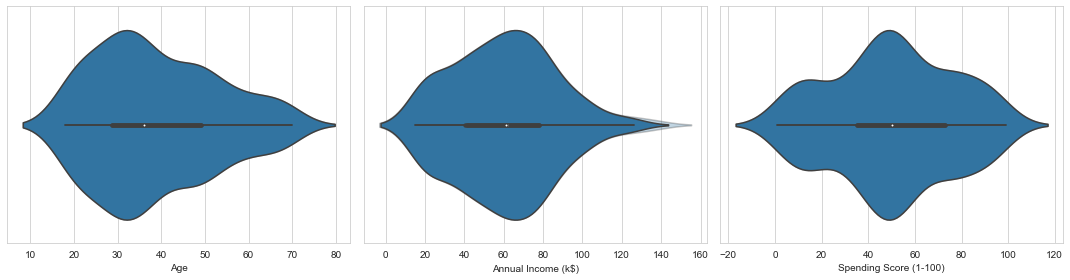

In [11]:
def treat_outiers(dataframe, col, **kwargs):
    """
    Treat outliers considering interquartile range.
    """     
    # Get keyword arguments
    column_action = kwargs.pop('column_action', 'remove')

    q1 = dataframe[col].quantile(0.25)
    q3 = dataframe[col].quantile(0.75)
    iqr = q3 - q1
    outlier_threshold = q3 + (iqr *1.5)
    outlier_indexes = 0
    if column_action == 'remove':
        outlier_indexes = np.where(dataframe[col] > outlier_threshold)[0]
        dataframe = dataframe[dataframe[col] < outlier_threshold]        
    
    return dataframe, outlier_indexes 

sns.set_style("whitegrid")
cols = ['Age', 'Annual Income (k$)','Spending Score (1-100)']
fig, axes = plt.subplots(nrows=1, ncols=len(cols), figsize=(15,4))

print('DataFrame size before outlier treatment: {0}'.format(df.shape))

ir = 0
outliers = []
for col in cols:
    ax = sns.violinplot(x=col, data=df, ax=axes[ir], label= col + ' --> outliers')
    plt.setp(ax.collections, alpha=.3)
    
    
    df, outlier_indexes = treat_outiers(df, col) 
    # Si existen outliers, se agregan a una lista para luego utilizarse.
    if len(outlier_indexes) > 1:
        outliers.append(outlier_indexes)
        
    sns.violinplot(x=col, data=df, ax=axes[ir], label=col + ' --> without outliers')
    ir += 1

fig.tight_layout()

print('DataFrame size after outlier treatment: {0}'.format(df.shape))

In [12]:
df_original.loc[outliers[0]]


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
198,199,Male,32,137,18
199,200,Male,30,137,83


Vemos las caracteristicas de los dos clientes (outliers)

# Escalado de variables 

(Se probó con y sin escalado el codigo sin generar un cambio significativo en los resultados, pero eventualmente se lo puede considerar)


In [13]:


#scaler = StandardScaler()
#columns = ['Age', 'Annual Income (k$)','Spending Score (1-100)']
#for col in columns:
#    df[col] = scaler.fit_transform(df[[col]])
    
X1 = df[['Spending Score (1-100)', 'Annual Income (k$)']]
    
            

## Kmeans

Metodo del codo

In [14]:
# Preparamos una lista donde vamos a ir agregando las distancias medias
Sum_of_squared_distances = []
# Fiteammos un modelo para cada numero de cluster que queremos testear
K = np.arange(2,10)
for k in K:
    # Definimos y entrenamos el modelo
    km = KMeans(n_clusters=k)
    km = km.fit(X1)
    # Calculamos la distancia media y agregamos a la lista
    distancia_total = km.inertia_
    distancia_media = np.divide(distancia_total,X1.shape[0])
    Sum_of_squared_distances.append(distancia_media)

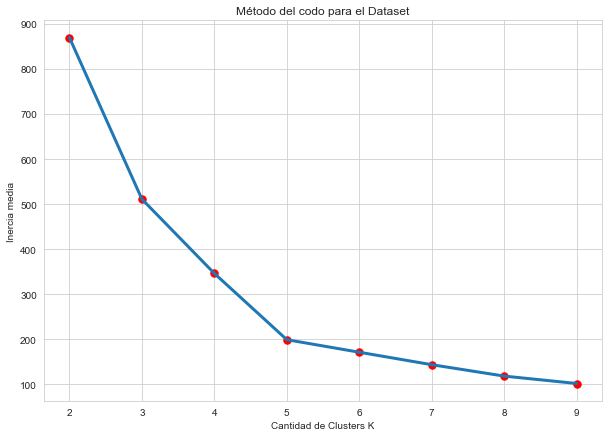

In [15]:
plt.figure(figsize = (10,7))
plt.plot(K, Sum_of_squared_distances, lw=3)
plt.scatter(K, Sum_of_squared_distances,s=55,c='r')
plt.xlabel('Cantidad de Clusters K')
plt.ylabel('Inercia media')
plt.title('Método del codo para el Dataset')
plt.show()

Vemos que en 5 es donde se produco el quiebre de la curva

## Metodo de la silueta

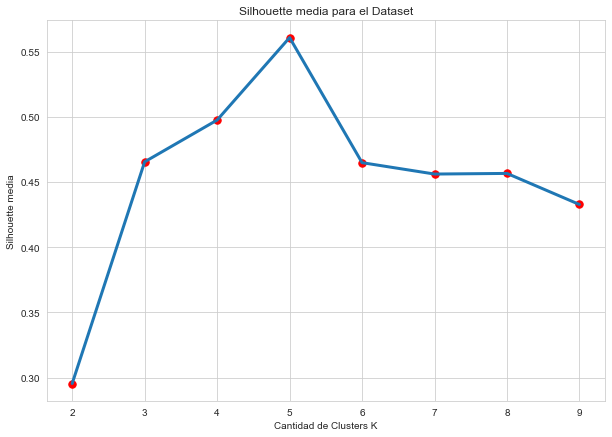

In [16]:
# Preparamos una lista donde vamos a ir agregando los valores medios de silhouette
lista_sil = []
# Fiteammos un modelo para cada numero de cluster que queremos testear
for k in range(2,10):
    # Definimos y entrenamos el modelo
    km = KMeans(n_clusters=k)
    km = km.fit(X1)
    
    # Tomamos las etiquetas
    etiquetas = km.labels_
    
    # Calculamos el silhouette 
    valor_medio_sil = silhouette_score(X1, etiquetas)
    lista_sil.append(valor_medio_sil)
    
plt.figure(figsize = (10,7))
plt.plot(K, lista_sil, lw=3)
plt.scatter(K, lista_sil,s=55,c='r')
plt.xlabel('Cantidad de Clusters K')
plt.ylabel('Silhouette media')
plt.title('Silhouette media para el Dataset')

plt.show()

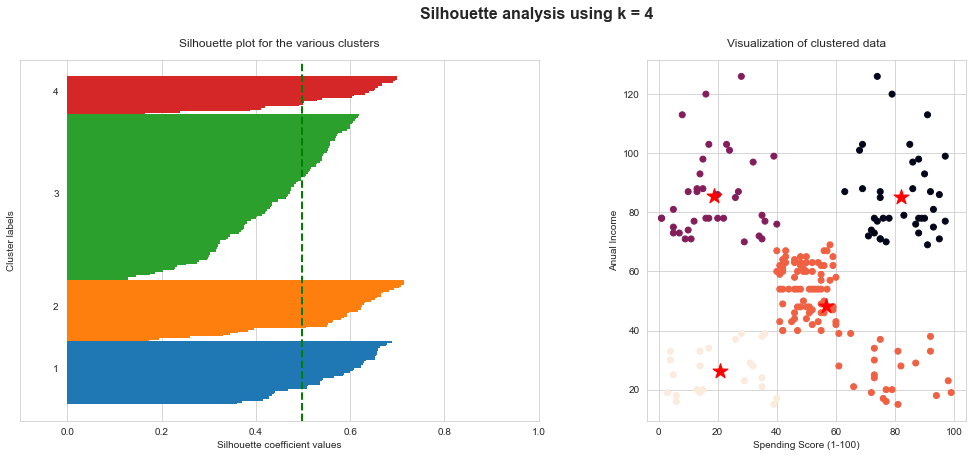

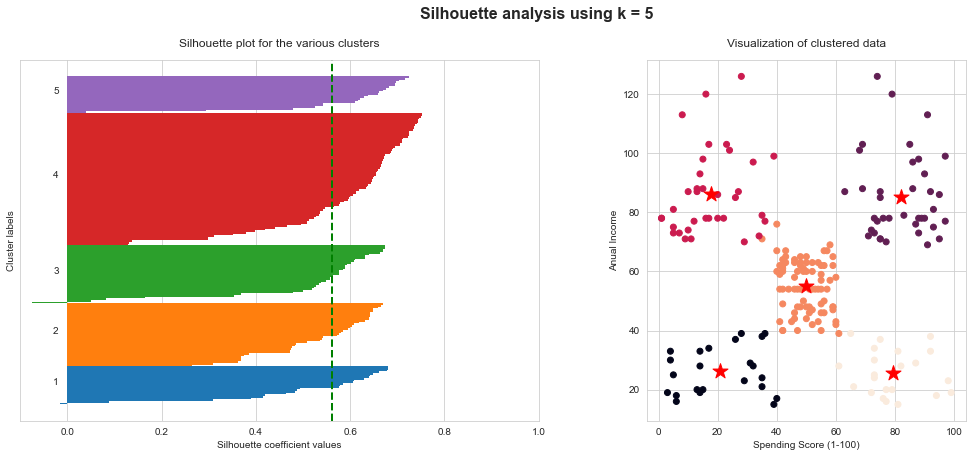

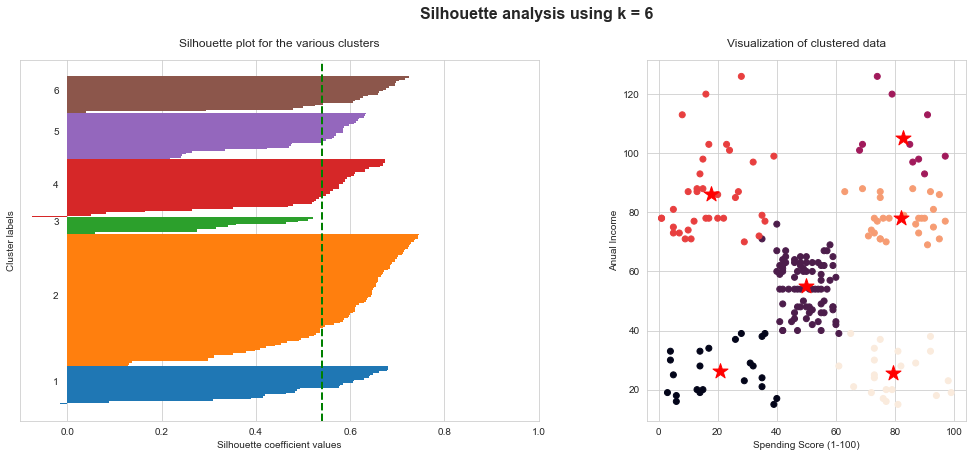

In [17]:
# Aca ponen el Dataset con el que quieren trabajar
X_std = X1
# Aca definen la lista de ks para los cuales quieren hacer un gráfico
k_list = [4, 5, 6]

for i, k in enumerate(k_list):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(X_std)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(X_std, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02);
    
    # Scatter plot of data colored with labels
    ax2.scatter(X_std.iloc[:, 0], X_std.iloc[:, 1], c=labels)
    ax2.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='r', s=250)
    ax2.set_xlabel('Spending Score (1-100)')
    ax2.set_ylabel('Anual Income')
    ax2.set_title('Visualization of clustered data', y=1.02)
    ax2.set_aspect('equal')
    plt.tight_layout()
    plt.suptitle(f'Silhouette analysis using k = {k}',
                 fontsize=16, fontweight='semibold', y=1.05);

Vemos que para ambos metodos el valor de clusters óptimo seria 5, aunque tambien podriamos considerar 6 pero no tenemos información sobre el negocio para evaluar la división del cluster central.

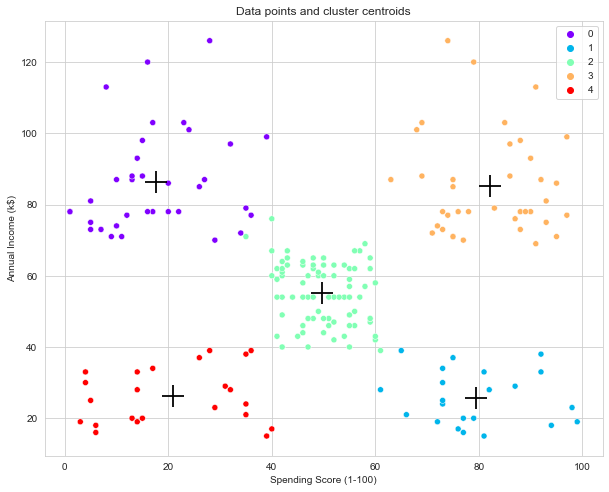

In [18]:
kmeans = KMeans(n_clusters = 5, random_state = 0)

km = kmeans.fit(X1)
# Obtengo la posición de los centros y las etiquetas
etiquetas_ = km.labels_
centros_ = km.cluster_centers_
# Plotting the cluster centers and the data points on a 2D plane
plt.figure(figsize=(10,8))
sns.scatterplot(x=X1['Spending Score (1-100)'],y=X1['Annual Income (k$)'], hue = etiquetas_,palette="rainbow")


sns.scatterplot(x=centros_[:, 0],y= centros_[:, 1],color='black', marker="+", s=500)
plt.title('Data points and cluster centroids')
plt.show()

De éste último gráfico podemos ver que los clientes pueden ser agrupados en al menos 5 grupos distintos basados en su ingreso anual y su score de gastos.

* **Rojo:** Bajo ingreso anual, bajo puntaje de gasto.
* **Violeta:** Alto ingreso anual, bajo puntaje de gasto.
* **Azul:** ingreso anual intermedio, puntaje de gasto intermedio
* **Verde:** Alto ingreso anual, alto puntaje de gasto.
* **Naranja:** bajo ingreso anual, alto puntaje de gasto.


* Se agregan los labels de cada cluster obtenidos con la clusterización al DataFrame original para poder generar un gráfico de proporciones

## Agregado de etiquetas y outliers al dataset

In [19]:

x = df_original.loc[outliers[0], ['Spending Score (1-100)', 'Annual Income (k$)']]
outliers_kmeans_labels = kmeans.predict(x)
# DataFrame Outliers
df_outliers = df_original.loc[outliers[0], ['CustomerID','Gender', 'Age', 'Spending Score (1-100)', 'Annual Income (k$)']]
display_html(df_outliers)
# Se convierte la variable categórica Género a numérica
df_outliers['Gender'] = df_outliers['Gender'].map(gender_mapper)
# Se asignan los outliers a los cluster armados
df_outliers['KMEANS_labels']= outliers_kmeans_labels
display_html(df_outliers)
# Se agregan los outliers clasificados al dataset

df = pd.concat([df, df_outliers])

,CustomerID,Gender,Age,Spending Score (1-100),Annual Income (k$)
198,199,Male,32,18,137
199,200,Male,30,83,137


,CustomerID,Gender,Age,Spending Score (1-100),Annual Income (k$),KMEANS_labels
198,199,1,32,18,137,0
199,200,1,30,83,137,3


In [20]:
df['KMEANS_labels'] = np.zeros((df.shape[0])).astype(int)
for k in range(kmeans.n_clusters):
    ix = np.where(kmeans.labels_ == k)[0]
    df.loc[ix, 'KMEANS_labels'] = k
    
df.tail()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),KMEANS_labels
195,196,0,35,120,79,3
196,197,0,45,126,28,0
197,198,1,32,126,74,3
198,199,1,32,137,18,0
199,200,1,30,137,83,0


In [21]:
gender_mapper = {0: 'Female', 1: 'Male'}
df['Gender'] = df['Gender'].map(gender_mapper)
df.tail()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),KMEANS_labels
195,196,Female,35,120,79,3
196,197,Female,45,126,28,0
197,198,Male,32,126,74,3
198,199,Male,32,137,18,0
199,200,Male,30,137,83,0


# Análisis de los clusters encontrados

KMEANS_labels,Age,Annual Income (k$),Spending Score (1-100)
0,40,89,19
1,25,26,79
2,43,55,50
3,33,85,82
4,45,26,21


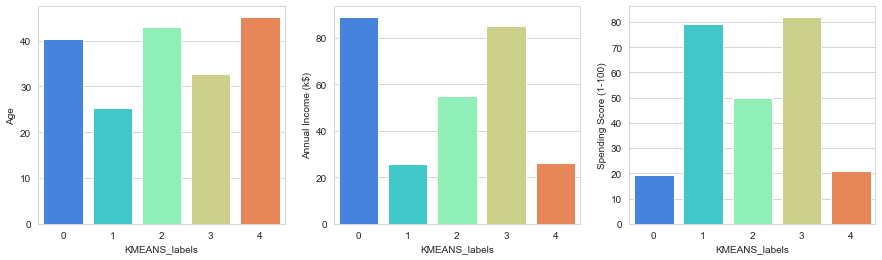

In [22]:
pd.set_option('precision', 0)

df2=df.drop(columns=['CustomerID'])
# Agrupo por label de cluster
#stats = df_kmeans.groupby(['kmeans_labels'], as_index=False).describe()
avg_data = df2.groupby(['KMEANS_labels'], as_index=False).mean()
std_data = df2.groupby(['KMEANS_labels'], as_index=False).std()
display_html(avg_data.style.hide_index())
# display_html(std_data.style.hide_index())


fig, axs = plt.subplots(1, 3, figsize=(15,4))
sns.barplot(x='KMEANS_labels',y='Age',palette="rainbow",data=avg_data, ax=axs[0])
sns.barplot(x='KMEANS_labels',y='Annual Income (k$)',palette="rainbow",data=avg_data, ax=axs[1])
sns.barplot(x='KMEANS_labels',y='Spending Score (1-100)',palette="rainbow",data=avg_data, ax=axs[2])
plt.show()

## Identificación de los tipos de clientes

* Cluster 0: Edad promedio 41 años;ingreso anual promedio 88k dolares; puntaje de gasto promedio 18
* Cluster 1: Edad promedio 43 años;ingreso anual promedio 55k dolares; puntaje de gasto promedio 50
* Cluster 2: Edad promedio 33 años;ingreso anual promedio 87k dolares; puntaje de gasto promedio 82
* Cluster 3: Edad promedio 25 años;ingreso anual promedio 26k dolares; puntaje de gasto promedio 79
* Cluster 4: Edad promedio 45 años;ingreso anual promedio 26k dolares; puntaje de gasto promedio 21


* **Cluster 0:** Cliente ocasional

Son clientes que a pesar de poseer altos ingresos, poseen un bajo puntaje de gasto, seguramente este ahorrando para algún gasto mayor (compra de un bien durable importante) o la jubilación.


* **Cluster 1:** Cliente de compra regular

Son clientes moderados, que suelen pensar en que gastar, de acuerdo a su ingreso, seguramente piensen mucho las compras que realicen, pero no dudan (si su capacidad de gasto financiera se lo permite) en adquirir un bien.


* **Cluster 2:** Cliente de compra frecuente

Son clientes que poseen un alto ingreso y puntaje de gasto, clientes que quieren tener los productos y que pueden afrontar los gastos que esto requiere.


* **Cluster 3:** Cliente-embajador

on clientes que si bien poseen bajos ingresos poseen un alto puntaje de gasto, son clientes que seguramente no estén pensando en ahorrar, sino en comprar y satisfacer sus necesidades de forma rápida.


* **Cluster 4:** Cliente-ahorrador

Son clientes que no poseen grandes niveles de ingresos y por tanto no gastan demasiado, clientes que seguramente actúan con mesura, y que piensen más en ahorrar que en comprar bienes. 



In [23]:
labels_mapper = {0: 'Cliente ocasional', 
                 1: 'Cliente de compra regular', 
                 2: 'Cliente de compra frecuente', 
                 3: 'Cliente embajador',
                 4: 'Cliente ahorrador'}
df['KMEANS_labels'] = df['KMEANS_labels'].map(labels_mapper)
df.tail()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),KMEANS_labels
195,196,Female,35,120,79,Cliente embajador
196,197,Female,45,126,28,Cliente ocasional
197,198,Male,32,126,74,Cliente embajador
198,199,Male,32,137,18,Cliente ocasional
199,200,Male,30,137,83,Cliente ocasional


# DBSCAN

In [24]:
Data_DBSCAN = df_original[['Annual Income (k$)','Spending Score (1-100)']].copy()

Lo primero que se debe determinar es cuál es el eps y el min_samples.
Epsilon define la máxima distancia entre dos puntos para que estos sean considerados del mismo grupo.

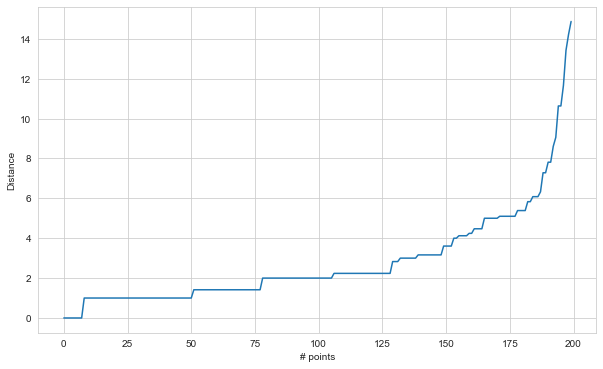

In [25]:
#selection of eps value

plt.figure(figsize=(10, 6))
neigh = NearestNeighbors(n_neighbors=k)
nbrs = neigh.fit(Data_DBSCAN)
distances, indices = nbrs.kneighbors(Data_DBSCAN)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.xlabel('# points')
plt.ylabel('Distance')       
plt.show()

In [26]:
#DBSCAN Algorithm
eps_val=9
min_samples_val=3
dbs = DBSCAN(eps=eps_val, min_samples=min_samples_val)
resultados=dbs.fit(Data_DBSCAN)


Luego de muchas pruebas encontramos que la combinación de epsilon=3 y minimas muestras=3 se parece más a la descripción realizada con KMEANS

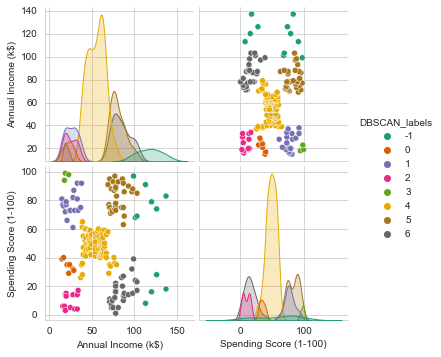

In [27]:
#Visualize DBSCAN clustering 
df_DBSCAN=Data_DBSCAN
df_DBSCAN['DBSCAN_labels']=resultados.labels_
sns.pairplot(df_DBSCAN,hue='DBSCAN_labels',palette='Dark2',diag_kind='kde')

In [28]:
#df['DBSCAN_labels'] = df_DBSCAN['DBSCAN_labels']
df['DBSCAN_labels'] = np.zeros((df.shape[0])).astype(int)
for k in range(resultados.labels_.shape[0]):
    ix = np.where(resultados.labels_ == k)[0]
    df.loc[ix, 'DBSCAN_labels'] = k

df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),KMEANS_labels,DBSCAN_labels
0,1,Male,19,15,39,Cliente ahorrador,0
1,2,Male,21,15,81,Cliente de compra regular,1
2,3,Female,20,16,6,Cliente ahorrador,2
3,4,Female,23,16,77,Cliente de compra regular,1
4,5,Female,31,17,40,Cliente ahorrador,0


## Clustering jerárquico
Se comienza el clustering jerarquico evaluando la totalidad de los niveles.

In [29]:
df_Agglomerative = df_original[['Annual Income (k$)','Spending Score (1-100)']].copy()

In [30]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(df_Agglomerative)

In [31]:
Z = hierarchy.linkage(model.children_, 'ward')

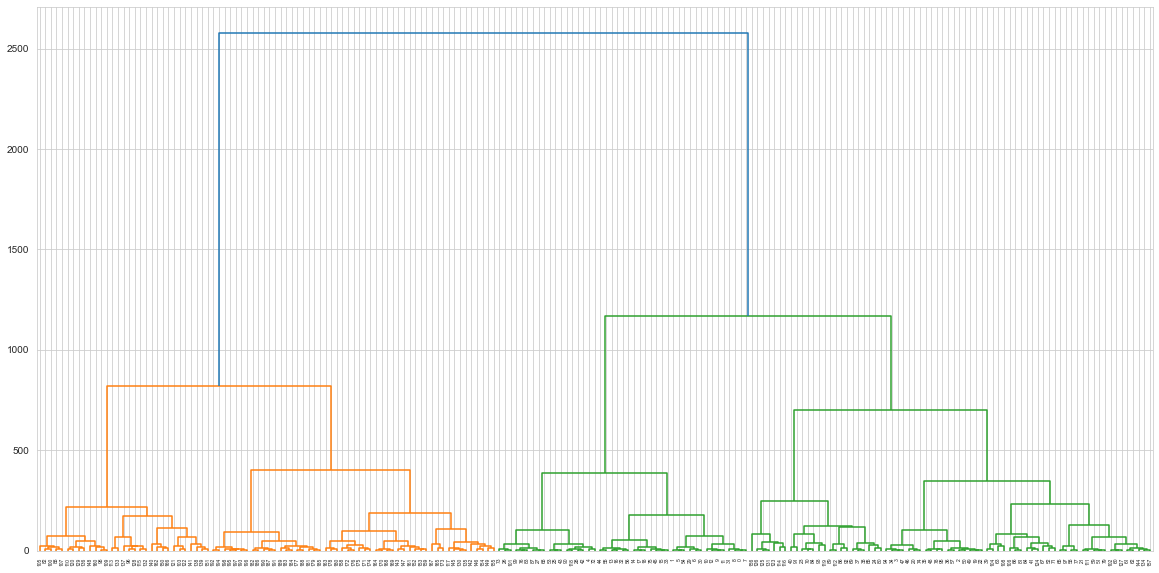

In [32]:
plt.figure(figsize=(20,10))
dn = hierarchy.dendrogram(Z)

Se adopta el corte en 5 Clusters para hacer la comparación con Kmeans

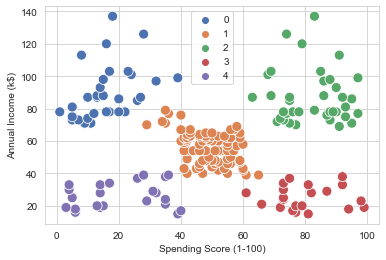

In [33]:
aggloclust = AgglomerativeClustering(n_clusters=5).fit(df_Agglomerative)
   
sns.scatterplot(x=df_Agglomerative['Spending Score (1-100)'],y=df_Agglomerative['Annual Income (k$)'],s=100,hue = aggloclust.labels_,palette="deep")
   
plt.show()

Agregamos las etiquetas


In [34]:
df['Agglomerative_labels'] = np.zeros((df.shape[0])).astype(int)
for k in range(aggloclust.n_clusters_):
    ix = np.where(aggloclust.labels_ == k)[0]
    df.loc[ix, 'Agglomerative_labels'] = k
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),KMEANS_labels,DBSCAN_labels,Agglomerative_labels
0,1,Male,19,15,39,Cliente ahorrador,0,4
1,2,Male,21,15,81,Cliente de compra regular,1,3
2,3,Female,20,16,6,Cliente ahorrador,2,4
3,4,Female,23,16,77,Cliente de compra regular,1,3
4,5,Female,31,17,40,Cliente ahorrador,0,4
